# Análise de Depressão Estudantil com Árvore de Decisão

Este notebook implementa um modelo de Árvore de Decisão para classificar estudantes com depressão usando o dataset de depressão estudantil. O foco principal é construir um modelo interpretável e controlar o overfitting através de técnicas de regularização.

## Objetivos
- Construir uma árvore de decisão para classificação binária (deprimido/não deprimido)
- Analisar o overfitting através dos erros Ein e Eout
- Aplicar técnicas de poda (pruning) para regularização
- Avaliar o desempenho do modelo otimizado

Carregamento de todas as bibliotecas necessárias para análise de dados, construção do modelo, validação e visualização dos resultados.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Carregar o conjunto de dados

Utilizamos o dataset pré-processado `Student_Depression_Cleaned.csv` que contém informações sobre estudantes e indicadores de depressão. Este dataset já passou por limpeza e engenharia de features.

In [2]:
df = pd.read_csv("../data/Student_Depression_Cleaned.csv", sep=',')

### 2. Definição das features e o target

As features foram selecionadas com base na análise exploratória prévia (EDA), considerando:
- **Academic Pressure**: Pressão acadêmica percebida pelo estudante
- **Have you ever had suicidal thoughts?**: Pensamentos suicidas (indicador crítico de saúde mental)
- **Weighted Stress**: Nível ponderado de estresse geral
- **Financial Stress**: Estresse relacionado a questões financeiras
- **Academic_Financial_Interaction**: Interação entre pressão acadêmica e estresse financeiro
- **Extreme_Mental_Crisis**: Indicador de crise mental extrema
- **Depression_Predisposition_Score**: Score de predisposição à depressão
- **Mental_Vulnerability_Score**: Score de vulnerabilidade mental
- **Mental_Health_Crisis_Index**: Índice de crise de saúde mental
- **Stress_Vulnerability_Multiplier**: Multiplicador de vulnerabilidade ao estresse
- **Ultimate_Depression_Predictor**: Preditor final combinado de depressão

In [3]:
features = [
    'Academic Pressure', 'Have you ever had suicidal thoughts ?','Weighted Stress',
    'Financial Stress','Extreme_Mental_Crisis','Mental_Vulnerability_Score','Mental_Health_Crisis_Index','Stress_Vulnerability_Multiplier',
    'Ultimate_Depression_Predictor','Family History of Mental Illness','Work/Study Hours',
]

X = df[features]
y = df['Depression']

### 3. Dividisão dos dados em conjuntos de treino e teste

Utilizamos uma divisão 70-30 com `random_state=2698` para garantir reprodutibilidade. Esta proporção é adequada para o tamanho do dataset, permitindo:
- **80% para treino**: Dados suficientes para o modelo aprender os padrões
- **20% para teste**: Amostra representativa para avaliação final

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2698)

print("Tamanho treino: " + str(len(X_train)))
print("Tamanho teste: " + str(len(X_test)))

Tamanho treino: 12696
Tamanho teste: 3174


### 4. Construir uma árvore de decisão com a instância de treino

Criamos uma árvore de decisão sem restrições para estabelecer uma linha de base. Esta árvore pode apresentar overfitting, que será posteriormente controlado através de técnicas de poda.

In [5]:
tree_initial = DecisionTreeClassifier(random_state=42, class_weight='balanced')
tree_initial.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


### 5. Computar Ein e Eout para analisar overfitting

Calculamos os erros dentro da amostra (Ein) e fora da amostra (Eout) para identificar possível overfitting:
- **Ein**: Taxa de erro nos dados de treino
- **Eout**: Taxa de erro nos dados de teste
- **Critério**: Se Ein < Eout e a diferença > 10%, há indícios de overfitting

In [6]:
y_train_pred_initial = tree_initial.predict(X_train)
y_test_pred_initial = tree_initial.predict(X_test)

ein = 1 - accuracy_score(y_train, y_train_pred_initial)
eout = 1 - accuracy_score(y_test, y_test_pred_initial)

print(f"Erro dentro da amostra (Ein): {ein:.4f}")
print(f"Erro fora da amostra (Eout): {eout:.4f}")

if ein < eout and (eout - ein) > 0.1:
    print("Possível Overfitting")
else:
    print("Árvore Equilibrada")

Erro dentro da amostra (Ein): 0.0605
Erro fora da amostra (Eout): 0.2306
Possível Overfitting


### 3. Plotar Árvore Inicial

A visualização da árvore permite entender:
- **Estrutura hierárquica**: Como as decisões são tomadas
- **Features mais importantes**: Quais aparecem nos primeiros níveis
- **Complexidade**: Profundidade e número de folhas
- **Interpretabilidade**: Regras de decisão claras

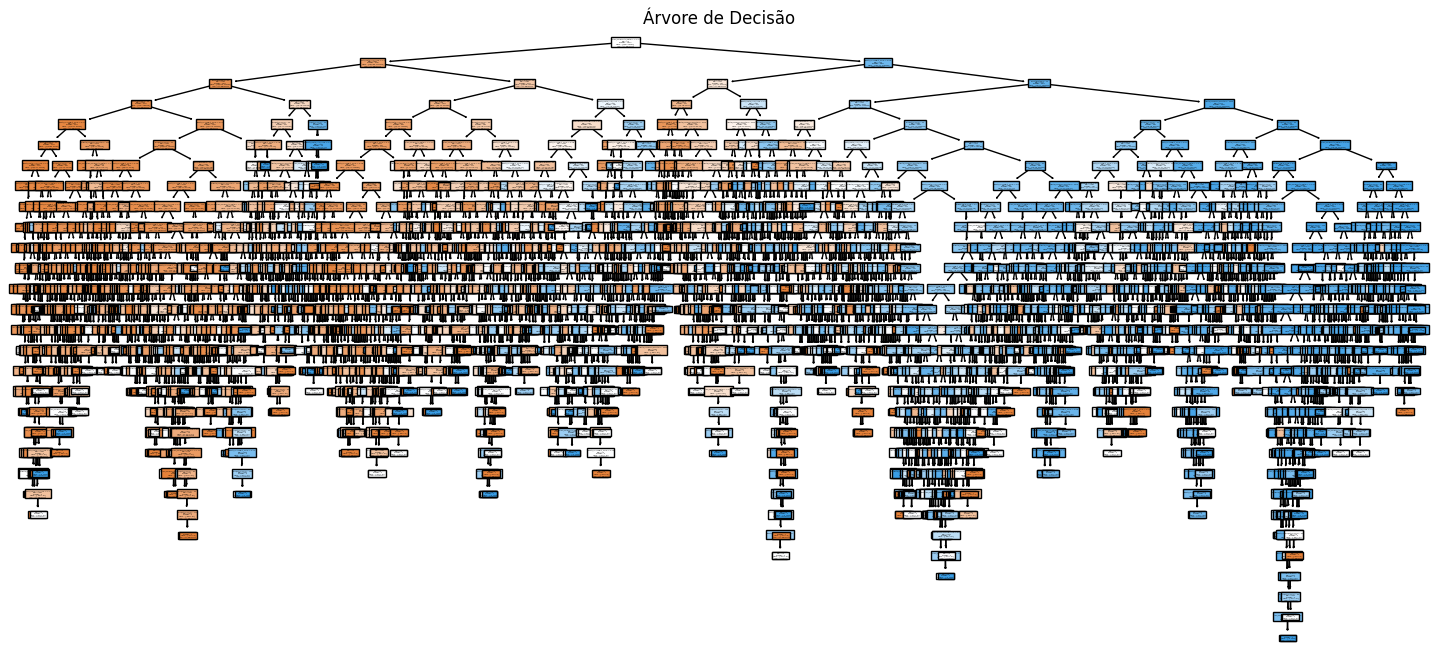

Profundidade da árvore: 29


In [7]:
plt.figure(figsize=(18, 8))
plot_tree(tree_initial, feature_names=features, class_names=['Não Depressivo', 'Depressivo'], filled=True)
plt.title("Árvore de Decisão")
plt.show()
print("Profundidade da árvore:", tree_initial.get_depth())

### 4. Regularização com Minimal Cost-Complexity Pruning

O **Minimal Cost-Complexity Pruning** é uma técnica que:
- Remove ramos que não contribuem significativamente para a performance
- Controla o trade-off entre complexidade e acurácia
- Utiliza o parâmetro α (alpha) para determinar o nível de poda
- Gera uma sequência de árvores com diferentes níveis de complexidade


Usado para podar nós da árvore evitando o surgimento de *overfitting*. Este algoritmo é parametrizado por $\alpha\geq0$ conhecido como parâmetro de complexidade da árvore. Este parâmetro é usado para definir o *cost-complexity* $R_{\alpha}(T)$ de uma dada árvore $T$, sendo a fórmula: 

> $R_{\alpha}(T)=R(T) + \alpha\cdot| leafes(T) |,$

onde:

*   $R(T) : $ são erros de classificação da árvore $T$ nos dados de treino;
*   $| leafes(T) | : $ número de folhas de decisão da árvore $T$.

O algoritmo *Minimal Cost-Complexity Pruning* procura a sub árvore que minimiza o $R_{\alpha}(T)$.

In [8]:
path = tree_initial.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

print(f"Encontrados {len(ccp_alphas)} valores de alpha para a poda.")

Encontrados 1561 valores de alpha para a poda.


### 5. Usar GridSearchCV para encontrar o melhor alpha com validação cruzada

Utilizamos **GridSearchCV** com validação cruzada de 10 folds para:
- Encontrar o valor ótimo de α (ccp_alpha)
- Evitar overfitting na seleção do hiperparâmetro
- Garantir que o modelo generaliza bem para dados não vistos
- Obter uma estimativa robusta da performance

In [9]:
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid={'ccp_alpha': ccp_alphas},
    cv=10,
    scoring='accuracy'
)
grid_search.fit(X_train, y_train)

best_tree = grid_search.best_estimator_
best_alpha = grid_search.best_params_['ccp_alpha']

print(f"Melhor valor de alpha (α) encontrado: {best_alpha:.6f}")

Melhor valor de alpha (α) encontrado: 0.001230


### 6. Avaliação da Melhor Árvore

Comparamos a performance da árvore podada com a árvore inicial:
- **Redução do overfitting**: Ein e Eout mais próximos
- **Melhor generalização**: Eout potencialmente menor
- **Maior robustez**: Modelo menos sensível a variações nos dados

In [10]:
y_train_pred_best = best_tree.predict(X_train)
y_test_pred_best = best_tree.predict(X_test)

ein_best = 1 - accuracy_score(y_train, y_train_pred_best)
eout_best = 1 - accuracy_score(y_test, y_test_pred_best)

print(f"Erro dentro da amostra (Ein): {ein_best:.4f}")
print(f"Erro fora da amostra (Eout): {eout_best:.4f}")

Erro dentro da amostra (Ein): 0.1790
Erro fora da amostra (Eout): 0.1824


### 7. Relatório de classificação

O relatório de classificação fornece métricas essenciais:
- **Precision**: Proporção de predições positivas corretas
- **Recall**: Proporção de casos positivos identificados
- **F1-Score**: Média harmônica entre precision e recall
- **Support**: Número de amostras de cada classe

In [11]:
print(classification_report(y_test, y_test_pred_best))

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1553
           1       0.83      0.81      0.82      1621

    accuracy                           0.82      3174
   macro avg       0.82      0.82      0.82      3174
weighted avg       0.82      0.82      0.82      3174



O modelo de Árvore de Decisão apresentou um desempenho equilibrado, com uma acurácia geral de 82%. As métricas de avaliação para as classes "Não Depressivo" (classe 0) e "Depressivo" (classe 1) foram bastante próximas, com precision, recall e F1-score em torno de 0.82 para ambas as classes. Isso indica que o modelo é capaz de identificar ambas as classes de forma consistente, sem favorecer uma classe em detrimento da outra.

### 8. Matriz de Confusão

A matriz de confusão permite analisar:
- **Verdadeiros Positivos (TP)**: Casos de depressão corretamente identificados
- **Falsos Positivos (FP)**: Casos incorretamente classificados como deprimidos
- **Verdadeiros Negativos (TN)**: Casos sem depressão corretamente identificados
- **Falsos Negativos (FN)**: Casos de depressão não identificados (crítico na área de saúde)

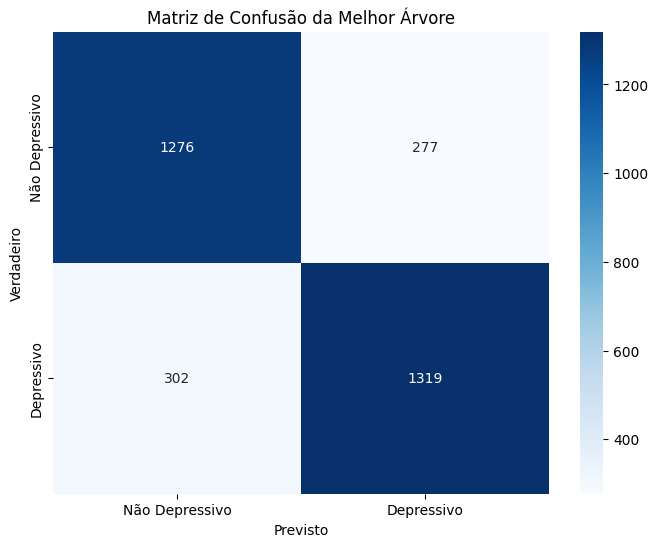

In [13]:
cm = confusion_matrix(y_test, y_test_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Depressivo', 'Depressivo'], yticklabels=['Não Depressivo', 'Depressivo'])
plt.title('Matriz de Confusão da Melhor Árvore')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

### 9. Melhor Árvore

A árvore final após a poda apresenta:
- **Estrutura simplificada**: Menor profundidade e número de folhas
- **Melhor interpretabilidade**: Regras mais claras e generalizáveis
- **Redução de overfitting**: Modelo mais robusto
- **Manutenção da performance**: Acurácia preservada com menor complexidade


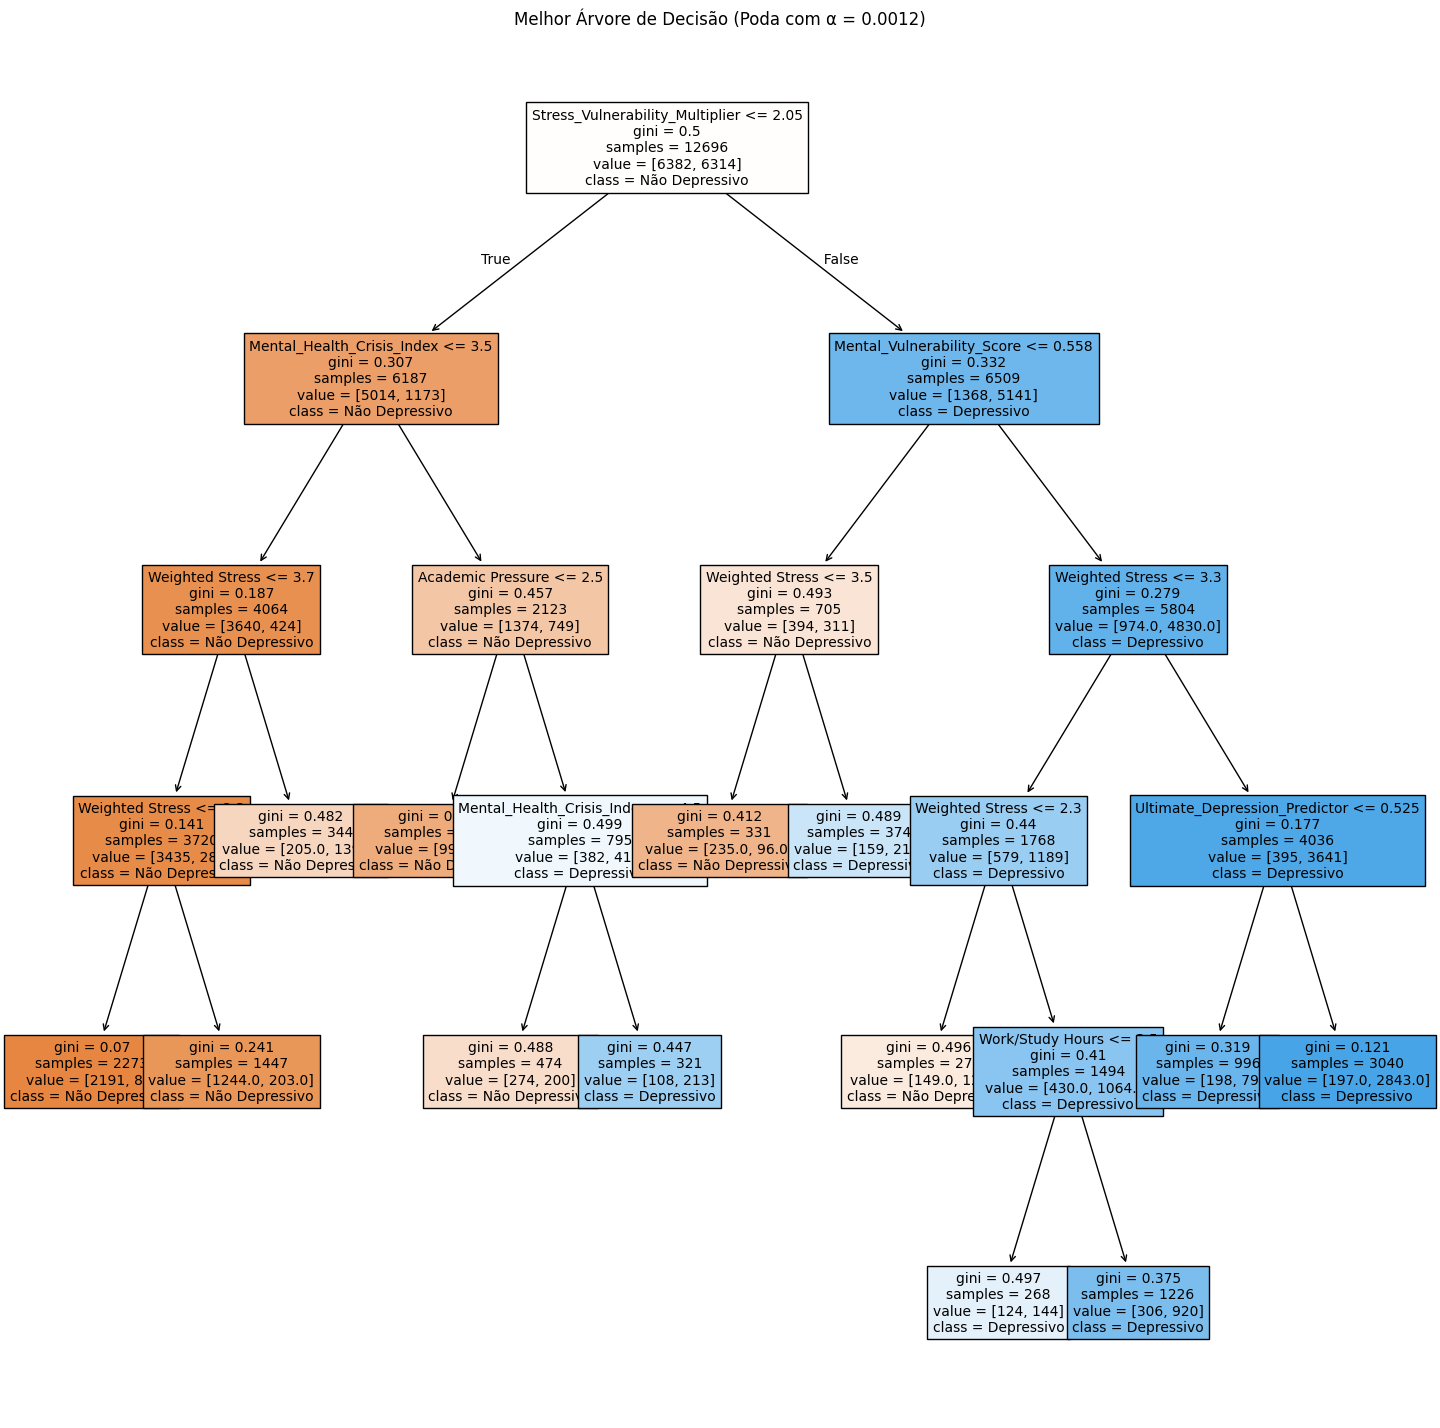

A árvore final tem 13 folhas e profundidade 5.


In [14]:
plt.figure(figsize=(18, 18))
plot_tree(best_tree,
          filled=True,
          feature_names=features,
          class_names=['Não Depressivo', 'Depressivo'],
          fontsize=10)
plt.title(f"Melhor Árvore de Decisão (Poda com α = {best_alpha:.4f})")
plt.show()

print(f"A árvore final tem {best_tree.get_n_leaves()} folhas e profundidade {best_tree.get_depth()}.")